In [1]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import re
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np

# Load and preprocess the dataset
def load_and_preprocess_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
        
    # Lowercase and remove non-alphanumeric characters except for periods and spaces
    text = re.sub(r"[^a-zA-Z0-9 .]+", " ", text).lower()
    
    # Split the text into sentences
    sentences = re.split(r' *[\.\?!][\'"\)\]]* *', text)
    
    # Remove empty sentences
    sentences = [s.strip() for s in sentences if len(s.strip()) > 0]
    
    return sentences

file_path = "merged_clean.txt"
sentences = load_and_preprocess_data(file_path)


[nltk_data] Downloading package punkt to /users/adcy347/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
len(sentences)

94905

In [4]:
def create_mappings(sentences, min_word_freq=8):
    # Tokenize the sentences using nltk's word_tokenize
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
    
    words = [word for tokenized_sentence in tokenized_sentences for word in tokenized_sentence]
    word_counts = Counter(words)
    
    # Filter out words with frequency less than min_word_freq
    vocab = [word for word, count in word_counts.items() if count >= min_word_freq]
    
    # Add special tokens
    vocab = ['<pad>', '<sos>', '<eos>', '<unk>'] + vocab
    
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    index_to_word = {idx: word for word, idx in word_to_index.items()}
    
    return word_to_index, index_to_word, vocab


In [5]:
# Encode sentences as sequences of indices, add <sos> and <eos> tokens, and split the dataset
def encode_sentences(sentences, word_to_index):
    encoded_sentences = []
    
    for sentence in sentences:
        tokenized_sentence = word_tokenize(sentence)
        encoded_sentence = [word_to_index['<sos>']]
        for word in tokenized_sentence:
            encoded_sentence.append(word_to_index.get(word, word_to_index['<unk>']))
        encoded_sentence.append(word_to_index['<eos>'])
        
        encoded_sentences.append(torch.tensor(encoded_sentence))
    
    return encoded_sentences

In [6]:
word_to_index, index_to_word, vocab = create_mappings(sentences, min_word_freq=8)
vocab_size = len(word_to_index)

encoded_sentences = encode_sentences(sentences, word_to_index)
data_size = len(encoded_sentences)
test_split = int(data_size * 0.1)  # 10% for testing
val_split = int(data_size * 0.2)  # 10% for validation

test_data = encoded_sentences[:test_split]
val_data = encoded_sentences[test_split:val_split]
train_data = encoded_sentences[val_split:]

In [7]:
len(word_to_index)

10144

In [8]:
# Create DataLoader objects for training, validation, and testing sets
class PaddedDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def pad_collate_fn(batch):
    return pad_sequence(batch, batch_first=True, padding_value=word_to_index['<pad>'])

train_dataset = PaddedDataset(train_data)
val_dataset = PaddedDataset(val_data)
test_dataset = PaddedDataset(test_data)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn)


In [9]:
import numpy as np

def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            try:
                vector = np.asarray(values[1:], dtype="float32")
                embeddings[word] = vector
            except ValueError:
                print("Skipping line containing non-float value(s)")
    return embeddings




In [10]:
def create_embedding_matrix(embeddings, word_to_index, embedding_dim):
    vocab_size = len(word_to_index)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, index in word_to_index.items():
        if word in embeddings:
            embedding_matrix[index] = embeddings[word]
        else:
            embedding_matrix[index] = np.random.uniform(-0.1, 0.1, embedding_dim)
    
    return torch.tensor(embedding_matrix, dtype=torch.float32)

embedding_dim = 300


In [ ]:
glove_file_path = "./glove_embeddings/glove.840B.300d.txt"
glove_embeddings = load_glove_embeddings(glove_file_path)

In [21]:
# Save the embeddings dictionary to a file
with open('glove_embeddings.pkl', 'wb') as f:
    pickle.dump(glove_embeddings, f)

In [11]:
import pickle
# Load the saved embeddings when needed
with open('glove_embeddings.pkl', 'rb') as f:
    loaded_embeddings = pickle.load(f)

In [12]:
embedding_matrix = create_embedding_matrix(loaded_embeddings, word_to_index, embedding_dim)

In [28]:
# Define the encoder-decoder LSTM model
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, embedding_matrix, dropout_rate=0.3):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)  # Use the pre-trained embedding matrix
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        _, hidden = self.lstm(x)
        return hidden

class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, embedding_matrix, dropout_rate=0.3):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)  # Use the pre-trained embedding matrix
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x, hidden):
        x = self.embedding(x)
        x = self.dropout(x)
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)
        return output, hidden


In [29]:
# Initialize the encoder, decoder, loss function, and optimizer
hidden_dim = 512
num_layers = 2
learning_rate = 0.0001

encoder = Encoder(vocab_size, embedding_dim, hidden_dim, num_layers, embedding_matrix, dropout_rate=0.3).cuda()
decoder = Decoder(vocab_size, embedding_dim, hidden_dim, num_layers, embedding_matrix, dropout_rate=0.3).cuda()
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index['<pad>'])
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)


In [33]:
# Load the saved models
def load_models(encoder, decoder, encoder_checkpoint_path, decoder_checkpoint_path):
    encoder.load_state_dict(torch.load(encoder_checkpoint_path))
    decoder.load_state_dict(torch.load(decoder_checkpoint_path))

# Specify the paths to the saved models
encoder_checkpoint_path = "encoder_epoch_final40.pt"
decoder_checkpoint_path = "decoder_epoch_final40.pt"

# Initialize the models
encoder_loaded = Encoder(vocab_size, embedding_dim, hidden_dim, num_layers, embedding_matrix, dropout_rate=0.3).cuda()
decoder_loaded = Decoder(vocab_size, embedding_dim, hidden_dim, num_layers, embedding_matrix, dropout_rate=0.3).cuda()

# Load the saved models
load_models(encoder_loaded, decoder_loaded, encoder_checkpoint_path, decoder_checkpoint_path)


In [30]:
# Evaluate the model
def evaluate(encoder, decoder, dataloader, criterion):
    encoder.eval()
    decoder.eval()

    total_loss = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            inputs = batch.cuda()
            targets = batch.cuda()

            # Encoder
            encoder_hidden = encoder(inputs)

            # Decoder
            decoder_input = targets[:, :-1]
            decoder_target = targets[:, 1:].contiguous().view(-1)
            decoder_output, _ = decoder(decoder_input, encoder_hidden)

            # Compute loss
            loss = criterion(decoder_output.view(-1, vocab_size), decoder_target)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    
    # Restore the original modes
    encoder.train()
    decoder.train()
    
    return avg_loss

#val_loss = evaluate(encoder, decoder, val_loader, criterion)
#print(f"Validation loss: {val_loss:.4f}")


In [31]:
# Define the early stopping parameters
patience = 5  # Number of epochs to wait before stopping training
counter = 0  # Counter to track epochs without improvement
best_val_loss = float('inf')  # Initialize the best validation loss


In [32]:
# Train the model
def train_and_validate(encoder, decoder, train_loader, val_loader, criterion, optimizer, epochs, save_interval, weight_decay=1e-5):
    encoder.train()
    decoder.train()
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(epochs):
        total_train_loss = 0
        
        for batch_idx, batch in enumerate(train_loader):
            inputs = batch.cuda()
            targets = batch.cuda()
            
            # Encoder
            encoder_hidden = encoder(inputs)
            
            # Decoder
            decoder_input = targets[:, :-1]
            decoder_target = targets[:, 1:].contiguous().view(-1)
            decoder_output, _ = decoder(decoder_input, encoder_hidden)
            
            # Compute loss and update weights
            loss = criterion(decoder_output.view(-1, vocab_size), decoder_target)
            
            # Add L2 regularization
            l2_reg = torch.tensor(0.).cuda()
            for param in encoder.parameters():
                l2_reg += torch.norm(param, p=2)
            for param in decoder.parameters():
                l2_reg += torch.norm(param, p=2)
            loss += weight_decay * l2_reg
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validate
        val_loss = evaluate(encoder, decoder, val_loader, criterion)
        val_losses.append(val_loss)
        
        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        
            print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        
            # Save the model every 20 epochs
            if (epoch + 1) % save_interval == 0:
                torch.save(encoder.state_dict(), f"encoder_epoch_advanced{epoch + 1}.pt")
                torch.save(decoder.state_dict(), f"decoder_epoch_advanced{epoch + 1}.pt")
        # early stopping
        else:
            counter += 1
            print(f"Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                print("Early stopping triggered.")
                torch.save(encoder.state_dict(), f"encoder_epoch_advanced{epoch + 1}.pt")
                torch.save(decoder.state_dict(), f"decoder_epoch_advanced{epoch + 1}.pt")
                break
            
    return train_losses, val_losses


Epoch 1/1000, Training Loss: 6.4286, Validation Loss: 6.4055
Epoch 2/1000, Training Loss: 6.0232, Validation Loss: 6.0747
Epoch 3/1000, Training Loss: 5.7165, Validation Loss: 5.8595
Epoch 4/1000, Training Loss: 5.5377, Validation Loss: 5.7489
Epoch 5/1000, Training Loss: 5.4047, Validation Loss: 5.6017
Epoch 6/1000, Training Loss: 5.2176, Validation Loss: 5.4519
Epoch 7/1000, Training Loss: 5.0915, Validation Loss: 5.3569
Epoch 8/1000, Training Loss: 4.9776, Validation Loss: 5.2485
Epoch 9/1000, Training Loss: 4.8606, Validation Loss: 5.1464
Epoch 10/1000, Training Loss: 4.7415, Validation Loss: 5.0302
Epoch 11/1000, Training Loss: 4.6203, Validation Loss: 4.9319
Epoch 12/1000, Training Loss: 4.5044, Validation Loss: 4.8522
Epoch 13/1000, Training Loss: 4.3941, Validation Loss: 4.7556
Epoch 14/1000, Training Loss: 4.2864, Validation Loss: 4.6643
Epoch 15/1000, Training Loss: 4.1793, Validation Loss: 4.5756
Epoch 16/1000, Training Loss: 4.0839, Validation Loss: 4.4946
Epoch 17/1000, Tr

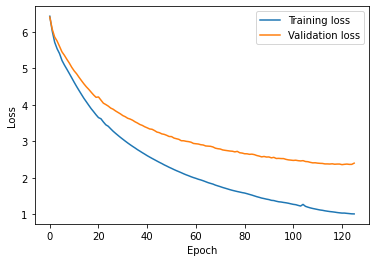

In [33]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

save_interval = 20
epochs = 1000
train_losses, val_losses = train_and_validate(encoder, decoder, train_loader, val_loader, criterion, optimizer, epochs, save_interval)
plot_losses(train_losses, val_losses)

In [34]:
val_loss = evaluate(encoder, decoder, val_loader, criterion)
print(f"Validation loss: {val_loss:.4f}")

Validation loss: 2.4010


In [24]:
# Generate new text
def generate_text(encoder, decoder, seed_text, max_length=50, temperature=1.0):
    encoder.eval()
    decoder.eval()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    with torch.no_grad():
        # Encode seed text
        seed_tokens = ["<sos>"] + word_tokenize(seed_text) + ["<eos>"]
        seed_indices = [word_to_index.get(word, word_to_index['<unk>']) for word in seed_tokens]
        seed_tensor = torch.tensor(seed_indices).cuda().unsqueeze(0)
        encoder_hidden = encoder(seed_tensor)

        # Initialize decoder input with the <eos> token
        decoder_input = torch.tensor([word_to_index['<eos>']]).cuda().unsqueeze(0)

        generated_text = seed_text

        for _ in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, encoder_hidden)
            probabilities = torch.softmax(decoder_output / temperature, dim=-1)

            # Sample a token from the probability distribution
            next_token_idx = torch.multinomial(probabilities.view(-1), 1).item()

            if next_token_idx == word_to_index['<eos>']:
                break

            generated_text += " " + index_to_word[next_token_idx]
            decoder_input = torch.tensor([next_token_idx]).cuda().unsqueeze(0)

    return generated_text


In [25]:
#seed_text = "In a mystical land far away, there was an enchanted forest where magical creatures lived."
#generated_text = generate_text(seed_text, model, tokenizer, max_length=100)

seed_text = "Once upon a time a young prince"
generated_output = generate_text(encoder, decoder, seed_text)
print(generated_output)

Once upon a time a young prince possesses requires chiming call scream important inquired sheehogues search beheld know countless fairy named digging foretold compel steep father fireworks ardan carpenter met reminded observations jewish digested an represented true urashima mightier ask superior nonsense only met malice lasso countess redbreast knowledge returning poor settled elfin consider within idea psalm


In [35]:
def perplexity(loss):
    return math.exp(loss)

# Calculate perplexity
test_loss = evaluate(encoder, decoder, test_loader, criterion)
average_test_perplexity = perplexity(test_loss)
print(f"Average Test Perplexity: {average_test_perplexity:.4f}")


Average Test Perplexity: 6.1748
